In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob 
import os.path
import gensim
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

import seaborn as sb
import numpy as np
from textblob import TextBlob 

In [2]:
url ='https://fangj.github.io/friends/'

In [3]:
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [4]:
links = soup.find_all('a')

In [5]:
a_script =[]
cc=0
script_dict ={}
for l in links:
    st = l.get_text().split(' ')
    if(len(st[0].strip())>=4):
        season = int(st[0][0:2])
        episode = st[0][2:]
    else:
        season = int(st[0][0])
        episode = st[0][1:]
    title = ' '.join(st[1:]).strip()
    surl = url + l['href']
    s_episode = requests.get(surl)
    soup = BeautifulSoup(s_episode.text, 'html.parser')
    dialogues = soup.find_all('p')
    script_start = False
    for d in dialogues:
        diag = d.get_text()
        diag = diag.split(':')
        if(script_start):
            if(len(diag)>1):
                a_script.append([season, episode, title, diag[0],diag[1]])
        elif(len(diag)>1 and diag[0]=='[Scene'):
            script_start = True
    script_dict.update({cc: a_script[cc]})
    cc = cc+1

In [6]:
friends_df = pd.DataFrame(a_script)

In [43]:
friends_df

,Season,Episode,Title,Character,Dialogue
0,1,01,Monica Gets A Roommate,Phoebe,"(singing) Love is sweet as\nsummer showers, l..."
1,1,01,Monica Gets A Roommate,[Scene,"Ross's Apartment, the guys are there assembli..."
2,1,01,Monica Gets A Roommate,Ross,(squatting and reading the instructions) I'm\...
3,1,01,Monica Gets A Roommate,Joey,I'm thinking we've got a\nbookcase here.
4,1,01,Monica Gets A Roommate,Chandler,It's a beautiful thing.
...,...,...,...,...,...
58246,10,17-1018,"The Last One, Part I & II",Chandler,"Oh, it's gonna be okay."
58247,10,17-1018,"The Last One, Part I & II",Rachel,(crying) Do you guys have to go to the new ho...
58248,10,17-1018,"The Last One, Part I & II",Monica,We got some time.
58249,10,17-1018,"The Last One, Part I & II",Rachel,"Okay, should we get some coffee?"


In [8]:
# gapminder.year.isin(years)
friends_df.columns = ['Season','Episode','Title','Character','Dialogue']

In [9]:
is_char = friends_df.Character.isin(['Phoebe','Ross','Chandler','Joey','Monica','Rachel'])

In [10]:
friends_char_df = friends_df[is_char]

In [11]:
phoebe_text = list(friends_char_df[friends_char_df.Character == 'Phoebe'].Dialogue)
ross_text = list(friends_char_df[friends_char_df.Character == 'Ross'].Dialogue)
chandler_text = list(friends_char_df[friends_char_df.Character == 'Chandler'].Dialogue)
joey_text = list(friends_char_df[friends_char_df.Character == 'Joey'].Dialogue)
monica_text = list(friends_char_df[friends_char_df.Character == 'Monica'].Dialogue)
rachel_text = list(friends_char_df[friends_char_df.Character == 'Rachel'].Dialogue)

In [12]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [13]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [14]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """

    d,dtm=prepare_corpus(doc_clean)
    lsa = LsiModel(dtm, num_topics=number_of_topics, id2word = d)
    return lsa 

In [15]:
def compute_coherence_values(term_dictionary, doc_term_matrix, cleaned_documents_list, start, stop, step):
    """
    Input: term_dictionary, doc_term_matrix, cleaned_documents_list, 
           start(Min. number of topics),
           stop(Max. num of topics)
           step(Step size when increasing the number of topics) 
    Output  : coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    # YOUR CODE HERE
    
    mlist = []
    cval = []
    for n in range(start, stop, step):
        m = LsiModel(doc_term_matrix, num_topics=n, id2word = term_dictionary)  
        mlist.append(m)
        cval.append(CoherenceModel(model=m, texts=cleaned_documents_list, dictionary=term_dictionary, coherence='c_v').get_coherence())
    return cval

In [16]:
def plot_graph(coherence_values,start, stop, step):
    '''
    Input: Coherence Values, Start, Stop, Step
    Output: N/A(Should not return anything, but should plot the graph between the number of topics and coherence values.)
    '''
    # YOUR CODE HERE
    plt.plot(range(start, stop, step), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.show()
    return

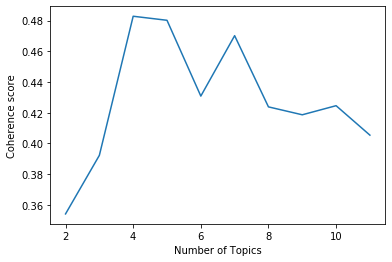

In [17]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(phoebe_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

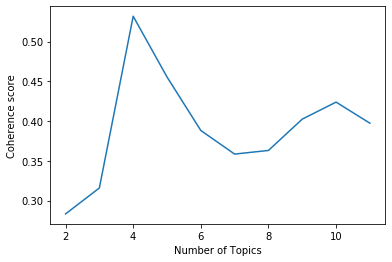

In [18]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(monica_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

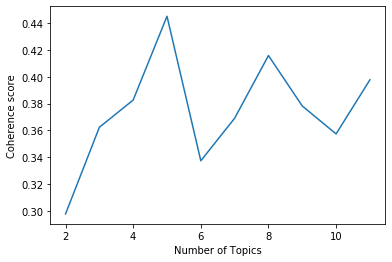

In [19]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(ross_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

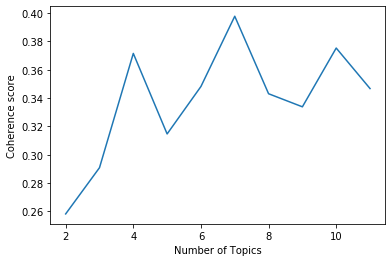

In [20]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(chandler_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

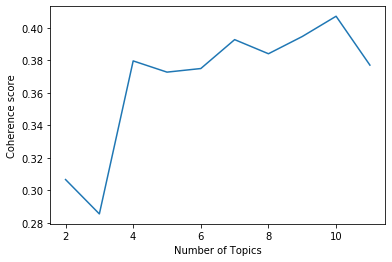

In [21]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(joey_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

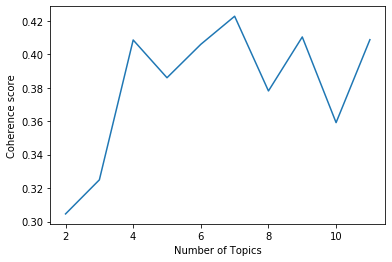

In [22]:
start,stop,step=2,12,1
clean_documents_list=preprocess_data(rachel_text)
term_dictionary, doc_term_matrix = prepare_corpus(clean_documents_list)
coherence_values = compute_coherence_values(term_dictionary, doc_term_matrix,clean_documents_list, start, stop, step)
plot_graph(coherence_values,start,stop,step)

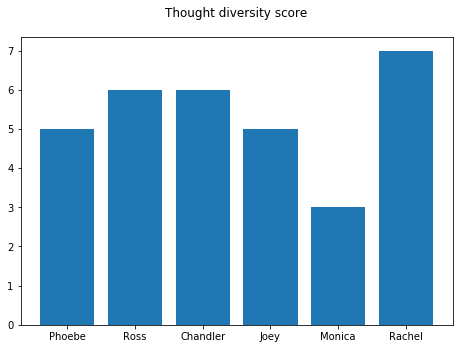

In [23]:
lchar = ['Phoebe','Ross','Chandler','Joey','Monica','Rachel']
ltopics =[5,6,6,5,3,7]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Thought diversity score', pad=20)
ax.bar(lchar,ltopics)
plt.show()

In [24]:
#As we can see, Rachel has most diverse nature of dialogues.This is evident from the above bar graph where we have analyzed number of topics in dialogues of each character in the Friends TV show.

In [25]:
#Building upon previous work, now we will try to understand personality of each character through the topics encountered in their speech

In [26]:
#Rachel's topic
# YOUR CODE HERE
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(rachel_text),number_of_topics,words)
rachel_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
rachel_topics

[(0,
  '0.663*"oh" + 0.400*"know" + 0.205*"okay" + 0.162*"ross" + 0.161*"god" + 0.132*"gonna" + 0.131*"get" + 0.121*"look" + 0.121*"yeah" + 0.121*"well"'),
 (1,
  '0.668*"oh" + -0.561*"know" + -0.223*"okay" + 0.185*"god" + -0.135*"mean" + -0.124*"well" + -0.114*"gonna" + -0.110*"right" + -0.097*"go" + -0.084*"get"'),
 (2,
  '-0.789*"okay" + 0.515*"know" + -0.117*"right" + -0.102*"get" + -0.100*"gonna" + -0.094*"ross" + -0.090*"go" + 0.084*"oh" + 0.083*"mean" + -0.079*"see"'),
 (3,
  '0.448*"yeah" + -0.435*"know" + -0.416*"okay" + 0.395*"well" + 0.198*"ross" + 0.160*"gonna" + 0.154*"go" + 0.151*"get" + 0.135*"look" + -0.133*"oh"'),
 (4,
  '0.758*"yeah" + -0.452*"ross" + 0.228*"okay" + -0.155*"get" + -0.138*"gonna" + -0.120*"go" + -0.117*"look" + -0.101*"mean" + 0.096*"know" + -0.083*"guy"'),
 (5,
  '-0.696*"well" + 0.524*"ross" + 0.381*"yeah" + 0.128*"mean" + -0.123*"go" + -0.110*"gonna" + 0.089*"look" + -0.070*"uh" + 0.066*"love" + 0.053*"come"'),
 (6,
  '-0.494*"ross" + -0.472*"well" 

In [27]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(monica_text),number_of_topics,words)
monica_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
monica_topics

[(0,
  '-0.389*"oh" + -0.350*"know" + -0.293*"get" + -0.288*"okay" + -0.263*"go" + -0.184*"chandler" + -0.172*"gonna" + -0.159*"right" + -0.143*"god" + -0.140*"mean"'),
 (1,
  '-0.775*"oh" + -0.307*"god" + 0.300*"7" + 0.215*"get" + 0.178*"know" + 0.168*"okay" + 0.160*"go" + 0.129*"2" + 0.081*"4" + 0.059*"think"'),
 (2,
  '-0.778*"7" + -0.330*"2" + -0.271*"oh" + -0.207*"4" + 0.200*"know" + -0.127*"3" + -0.125*"6" + -0.110*"god" + 0.107*"okay" + 0.098*"go"'),
 (3,
  '-0.712*"know" + 0.494*"get" + 0.305*"okay" + 0.237*"go" + -0.123*"7" + -0.107*"mean" + -0.105*"like" + 0.081*"phoeb" + -0.067*"think" + 0.060*"gonna"'),
 (4,
  '0.785*"okay" + -0.531*"get" + -0.212*"go" + -0.109*"know" + 0.058*"listen" + 0.057*"7" + 0.050*"chandler" + 0.044*"right" + -0.039*"well" + -0.035*"marri"'),
 (5,
  '0.736*"go" + -0.534*"get" + -0.204*"know" + -0.201*"okay" + 0.138*"gonna" + 0.107*"right" + 0.084*"chandler" + 0.081*"guy" + 0.066*"hey" + 0.064*"let"'),
 (6,
  '0.543*"chandler" + -0.367*"know" + -0.342

In [28]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(ross_text),number_of_topics,words)
ross_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
ross_topics

[(0,
  '-0.452*"know" + -0.320*"okay" + -0.281*"oh" + -0.246*"uh" + -0.211*"yeah" + -0.194*"look" + -0.186*"go" + -0.168*"get" + -0.161*"like" + -0.156*"mean"'),
 (1,
  '0.820*"okay" + -0.371*"oh" + -0.299*"know" + -0.186*"yeah" + -0.099*"uh" + 0.084*"go" + 0.066*"look" + -0.061*"god" + 0.054*"get" + 0.052*"right"'),
 (2,
  '0.756*"oh" + -0.585*"know" + 0.144*"okay" + 0.115*"god" + -0.097*"mean" + 0.079*"yeah" + 0.057*"hey" + 0.055*"uh" + -0.048*"go" + -0.041*"guy"'),
 (3,
  '-0.823*"yeah" + 0.292*"oh" + 0.278*"know" + -0.272*"uh" + 0.223*"hey" + 0.067*"god" + -0.065*"well" + 0.058*"look" + -0.056*"right" + -0.044*"listen"'),
 (4,
  '0.776*"hey" + 0.418*"uh" + -0.238*"know" + -0.229*"oh" + -0.217*"okay" + 0.096*"guy" + 0.095*"get" + -0.092*"yeah" + 0.074*"rachel" + 0.074*"enter"'),
 (5,
  '-0.760*"uh" + 0.450*"hey" + 0.396*"yeah" + -0.101*"well" + 0.082*"get" + 0.077*"right" + 0.074*"rachel" + -0.055*"like" + 0.047*"know" + 0.047*"look"'),
 (6,
  '-0.405*"know" + 0.389*"go" + -0.349*"o

In [29]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(phoebe_text),number_of_topics,words)
phoebe_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
phoebe_topics

[(0,
  '-0.537*"know" + -0.471*"oh" + -0.309*"okay" + -0.200*"like" + -0.183*"yeah" + -0.150*"look" + -0.141*"well" + -0.136*"get" + -0.123*"right" + -0.120*"guy"'),
 (1,
  '-0.771*"oh" + 0.581*"know" + -0.143*"god" + 0.119*"like" + -0.055*"look" + 0.053*"realli" + 0.047*"well" + 0.047*"gonna" + 0.042*"mean" + 0.036*"okay"'),
 (2,
  '0.780*"okay" + -0.439*"know" + -0.284*"oh" + 0.126*"right" + 0.112*"well" + 0.110*"get" + 0.093*"go" + -0.068*"like" + 0.068*"gonna" + 0.066*"look"'),
 (3,
  '0.862*"yeah" + -0.286*"okay" + -0.257*"know" + -0.147*"oh" + 0.103*"look" + 0.094*"go" + 0.087*"well" + 0.076*"realli" + 0.073*"right" + 0.067*"monica"'),
 (4,
  '-0.426*"yeah" + -0.359*"okay" + 0.355*"like" + 0.306*"look" + 0.252*"hey" + -0.249*"know" + 0.242*"guy" + 0.213*"go" + -0.158*"oh" + 0.149*"get"'),
 (5,
  '0.697*"like" + -0.380*"go" + -0.300*"gonna" + -0.236*"well" + 0.181*"okay" + -0.169*"get" + 0.139*"look" + -0.113*"right" + -0.107*"want" + 0.105*"ross"'),
 (6,
  '-0.688*"well" + 0.483*

In [30]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(joey_text),number_of_topics,words)
joey_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
joey_topics

[(0,
  '0.405*"know" + 0.300*"hey" + 0.297*"look" + 0.269*"yeah" + 0.252*"oh" + 0.224*"like" + 0.221*"right" + 0.178*"okay" + 0.164*"uh" + 0.162*"ross"'),
 (1,
  '0.868*"hey" + -0.360*"yeah" + -0.260*"know" + -0.104*"like" + 0.078*"ross" + 0.076*"enter" + -0.069*"oh" + -0.048*"well" + 0.041*"guy" + -0.041*"look"'),
 (2,
  '-0.683*"yeah" + 0.471*"know" + -0.429*"oh" + 0.240*"look" + -0.153*"hey" + 0.075*"like" + -0.073*"uh" + 0.070*"right" + 0.054*"guy" + -0.052*"listen"'),
 (3,
  '0.620*"know" + -0.428*"look" + 0.288*"yeah" + 0.276*"hey" + -0.274*"okay" + -0.259*"right" + -0.203*"oh" + -0.173*"ross" + -0.072*"chandler" + -0.063*"joey"'),
 (4,
  '0.786*"oh" + -0.445*"yeah" + 0.223*"know" + -0.218*"right" + -0.196*"look" + 0.088*"uh" + -0.088*"like" + -0.078*"okay" + -0.074*"hey" + 0.066*"god"'),
 (5,
  '-0.691*"look" + 0.514*"right" + 0.246*"go" + 0.224*"get" + 0.152*"well" + 0.148*"okay" + -0.123*"yeah" + -0.114*"like" + -0.106*"hey" + -0.070*"oh"'),
 (6,
  '0.584*"right" + -0.419*"lik

In [31]:
number_of_topics=7
words=10
model=create_gensim_lsa_model(preprocess_data(chandler_text),number_of_topics,words)
chandler_topics = model.print_topics(num_topics=number_of_topics, num_words=words)
chandler_topics

[(0,
  '0.555*"know" + 0.248*"okay" + 0.237*"get" + 0.222*"go" + 0.220*"oh" + 0.205*"look" + 0.176*"well" + 0.166*"gonna" + 0.155*"like" + 0.144*"think"'),
 (1,
  '-0.725*"know" + 0.437*"okay" + 0.336*"oh" + 0.185*"joey" + 0.139*"go" + 0.116*"get" + 0.100*"right" + 0.095*"look" + 0.079*"yeah" + 0.077*"monica"'),
 (2,
  '0.716*"oh" + -0.563*"okay" + -0.247*"go" + 0.199*"yeah" + 0.092*"god" + -0.092*"gonna" + -0.088*"get" + 0.082*"well" + 0.075*"joey" + 0.062*"hey"'),
 (3,
  '0.620*"go" + -0.582*"okay" + -0.267*"oh" + -0.230*"know" + 0.183*"joey" + 0.133*"well" + 0.130*"look" + 0.107*"hey" + 0.099*"get" + 0.095*"right"'),
 (4,
  '-0.614*"go" + 0.471*"joey" + -0.346*"oh" + 0.343*"look" + 0.157*"well" + 0.142*"monica" + -0.113*"know" + 0.109*"get" + -0.104*"okay" + 0.095*"like"'),
 (5,
  '-0.821*"get" + 0.412*"look" + 0.130*"go" + 0.126*"like" + 0.117*"okay" + -0.104*"one" + 0.098*"monica" + -0.095*"kathi" + 0.090*"well" + -0.088*"gonna"'),
 (6,
  '-0.688*"joey" + 0.528*"look" + 0.254*"get

In [32]:
s= chandler_topics[0][1]
s.split('"')[1::2]

['know', 'okay', 'get', 'go', 'oh', 'look', 'well', 'gonna', 'like', 'think']

In [33]:
lchar2 = [ 'rachel', 'ross','monica','phoebe',  'joey','chandler']

In [34]:
topics_list = [rachel_topics, ross_topics, monica_topics, phoebe_topics, joey_topics, chandler_topics]
character_affinity =[]
for i in range(len(lchar2)):
    tp = topics_list[i]
    ca = [0 for i in range(6)]
    for j in range(len(lchar2)):
        for k, t in enumerate(tp):
            s = t[1].split('"')[1::2]
            if(lchar2[j] in s):
                ca[j] = ca[j]+1
    character_affinity.append(ca)
                
        

In [35]:
ca_df = pd.DataFrame(character_affinity)
ca_df.columns =lchar2
ca_df.index = lchar2
ca_df

,rachel,ross,monica,phoebe,joey,chandler
rachel,0,6,0,0,1,0
ross,2,0,0,0,0,0
monica,0,0,0,0,0,4
phoebe,0,1,2,0,0,1
joey,0,4,0,0,1,2
chandler,0,0,4,0,5,0


Text(0.5, 1, 'Character affinity heat map')

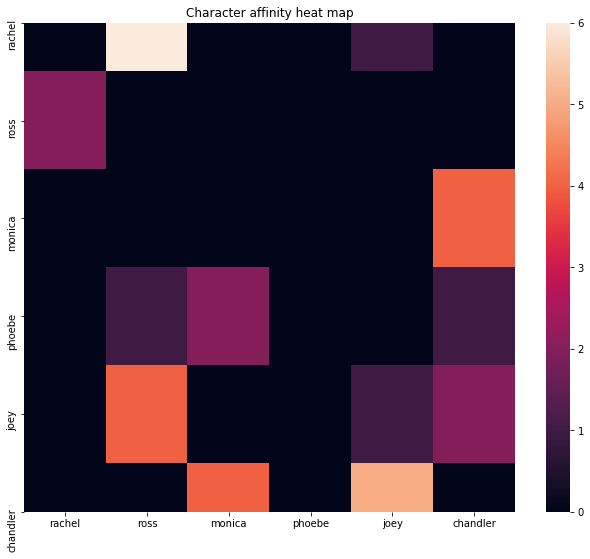

In [36]:
#plotting character affinity heatmap 
#Higher affinity towards one character means higher mentions of another character in the other character's key topics through out
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(ca_df)

# displaying the title 
plt.title("Character affinity heat map")

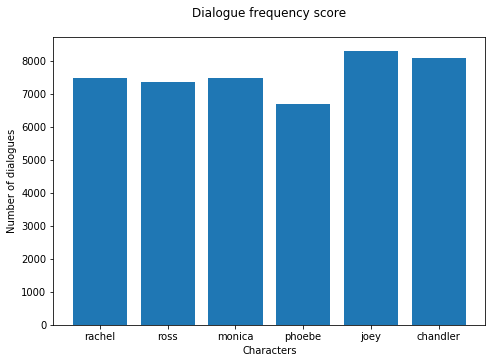

In [37]:
# Most important character by dialogues - Joey
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Dialogue frequency score", pad=20)
plt.xlabel('Characters')  
plt.ylabel('Number of dialogues') 
ax.bar(lchar2, friends_char_df.groupby(by=["Character"]).count()['Dialogue'])

plt.show()

In [38]:
# using TextBlob.sentiment method 
for i in friends_char_df.index:
    dialogue = friends_char_df.loc[i,'Dialogue']
    tb = TextBlob(dialogue)
    s=0
    if(tb.sentiment[0]>0):
        s =1
    elif(tb.sentiment[0]<0):
        s=-1
    friends_char_df.loc[i,'Sentiment'] =s

C:\Users\Apoorva\Documents\AnacondaInstallation\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Apoorva\Documents\AnacondaInstallation\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [39]:
actor_sentiment =[]
for actor in lchar2:
    cp = friends_char_df[friends_char_df.Character == actor.capitalize()][friends_char_df.Sentiment == 1].Sentiment.count()
    cn = friends_char_df[friends_char_df.Character == actor.capitalize()][friends_char_df.Sentiment == 0].Sentiment.count()
    c = friends_char_df[friends_char_df.Character == actor.capitalize()][friends_char_df.Sentiment == -1].Sentiment.count()
    s = cp+cn+c
    actor_sentiment.append([cp*100/s,c*100/s,cn*100/s])

C:\Users\Apoorva\Documents\AnacondaInstallation\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Apoorva\Documents\AnacondaInstallation\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\Apoorva\Documents\AnacondaInstallation\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


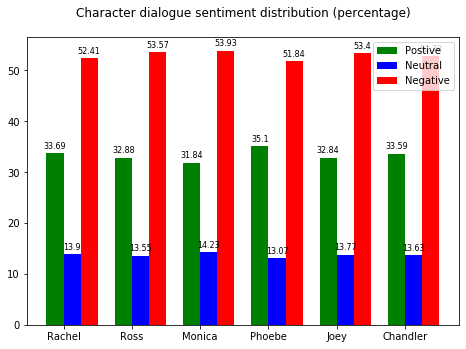

In [40]:
data_sent =  np.array(actor_sentiment).T.tolist()
X = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
r1 =ax.bar(X + 0.00, data_sent[0], color = 'g', width= 0.25)
r2 =ax.bar(X + 0.25, data_sent[1], color = 'b', width = 0.25)
r3 =ax.bar(X + 0.50, data_sent[2], color = 'r', width = 0.25)
ax.legend(labels=['Postive', 'Neutral','Negative'])
ax.set_title("Character dialogue sentiment distribution (percentage)", pad=20)
lchar2 = [l.capitalize() for l in lchar2]
plt.xticks(X + .25 /2, lchar2)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)


autolabel(r1)
autolabel(r2)
autolabel(r3)

plt.show()